In [1]:
%matplotlib inline


Transfer Learning tutorial
==========================
**Author**: `Sasank Chilamkurthy <https://chsasank.github.io>`_

In this tutorial, you will learn how to train your network using
transfer learning. You can read more about the transfer learning at `cs231n
notes <http://cs231n.github.io/transfer-learning/>`__

Quoting these notes,

    In practice, very few people train an entire Convolutional Network
    from scratch (with random initialization), because it is relatively
    rare to have a dataset of sufficient size. Instead, it is common to
    pretrain a ConvNet on a very large dataset (e.g. ImageNet, which
    contains 1.2 million images with 1000 categories), and then use the
    ConvNet either as an initialization or a fixed feature extractor for
    the task of interest.

These two major transfer learning scenarios look as follows:

-  **Finetuning the convnet**: Instead of random initializaion, we
   initialize the network with a pretrained network, like the one that is
   trained on imagenet 1000 dataset. Rest of the training looks as
   usual.
-  **ConvNet as fixed feature extractor**: Here, we will freeze the weights
   for all of the network except that of the final fully connected
   layer. This last fully connected layer is replaced with a new one
   with random weights and only this layer is trained.




In [13]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
plt.style.use("seaborn-white")
import time
import os
import copy

plt.ion()   # interactive mode

Load Data
---------

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we're going to solve today is to train a model to classify
**ants** and **bees**. We have about 120 training images each for ants and bees.
There are 75 validation images for each class. Usually, this is a very
small dataset to generalize upon, if trained from scratch. Since we
are using transfer learning, we should be able to generalize reasonably
well.

This dataset is a very small subset of imagenet.

.. Note ::
   Download the data from
   `here <https://download.pytorch.org/tutorial/hymenoptera_data.zip>`_
   and extract it to the current directory.



In [10]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
# torch.utils.data.Dataset's subclass implements __len__() method that returns length of datasets
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}  
class_names = image_datasets['train'].classes  # classes (list): List of the class names.

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [11]:
image_datasets["train"].class_to_idx  # class_to_idx (dict): Dict with items (class_name, class_index).

{'ants': 0, 'bees': 1}

https://github.com/pytorch/vision/blob/master/torchvision/datasets/folder.py#L75-L79

### Visualize a few images

Let's visualize a few training images so as to understand the data
augmentations.



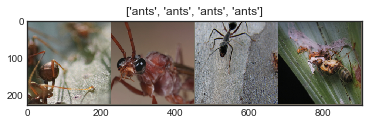

In [15]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [31]:
# from tqdm import tqdm_notebook as tqdm

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    epochs = range(num_epochs)
    for epoch in epochs:
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()  # calcurate lerning late
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)  # preds's shape is N x 1
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()  # calcurate gradient w.r.t loss
                        optimizer.step()  # optimize weight parameters of model

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(state_dict=best_model_wts)  # Copies parameters and buffers from state_dict into this module and its descendants. If 
    return model

### Visualizing the model predictions


Generic function to display predictions for a few images




In [19]:
def visualize_model(model, num_images=6):
    was_training = model.training  # training : boolean
    model.eval()  # model.training=False
    # print("after model.wval():", model.training)
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # print("model train:", model.training)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])  # Tensor.cpu send Tensor on gpu to cpu

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




In [20]:
model_ft = models.resnet18(pretrained=True)
print(model_ft)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /Users/yohei/.torch/models/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:22<00:00, 2046046.41it/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [22]:
model_ft.fc  # Moduleに名前でアクセス可能

Linear(in_features=512, out_features=1000, bias=True)

In [23]:
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)  # new layer with random initialization

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

### Train and evaluate

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [32]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6113 Acc: 0.7254
val Loss: 0.2882 Acc: 0.9020

Epoch 1/24
----------
train Loss: 0.5503 Acc: 0.7746
val Loss: 0.2243 Acc: 0.9216

Epoch 2/24
----------
train Loss: 0.6950 Acc: 0.7582
val Loss: 0.4662 Acc: 0.8431

Epoch 3/24
----------
train Loss: 0.6712 Acc: 0.7377
val Loss: 0.6574 Acc: 0.7712

Epoch 4/24
----------
train Loss: 0.7668 Acc: 0.7131
val Loss: 0.9982 Acc: 0.7386

Epoch 5/24
----------
train Loss: 0.6880 Acc: 0.8033
val Loss: 0.5429 Acc: 0.8235

Epoch 6/24
----------
train Loss: 0.3517 Acc: 0.8770
val Loss: 0.3347 Acc: 0.9085

Epoch 7/24
----------
train Loss: 0.3880 Acc: 0.8525
val Loss: 0.3180 Acc: 0.8954

Epoch 8/24
----------
train Loss: 0.3009 Acc: 0.8689
val Loss: 0.2885 Acc: 0.9085

Epoch 9/24
----------
train Loss: 0.3264 Acc: 0.8443
val Loss: 0.2903 Acc: 0.9020

Epoch 10/24
----------
train Loss: 0.3807 Acc: 0.8238
val Loss: 0.2494 Acc: 0.9150

Epoch 11/24
----------
train Loss: 0.2733 Acc: 0.8811
val Loss: 0.2888 Acc: 0.9085

Ep

after model.wval(): False
model train: False


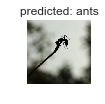

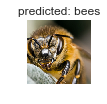

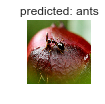

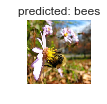

model train: False


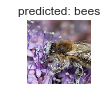

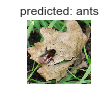

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x115147da0>>
Traceback (most recent call last):
  File "/Users/yohei/.pyenv/versions/3.6.4/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 349, in __del__
    self._shutdown_workers()
  File "/Users/yohei/.pyenv/versions/3.6.4/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 328, in _shutdown_workers
    self.worker_result_queue.get()
  File "/Users/yohei/.pyenv/versions/3.6.4/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/Users/yohei/.pyenv/versions/3.6.4/envs/pytorch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 86, in rebuild_storage_filename
    storage = cls._new_shared_filename(manager, handle, size)
RuntimeError: Interrupted system call at /Users/soumith/code/builder/wheel/pytorch-src/torch/lib/libshm/core.cpp:125


In [34]:
visualize_model(model_ft)

ConvNet as fixed feature extractor
----------------------------------

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad == False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

You can read more about this in the documentation
here <http://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>




In [48]:
b = torch.tensor([2,3], requires_grad=True)
with torch.no_grad():
    a = b*2
print("a_grad:", a.requires_grad)
print("b_grad:", b.requires_grad)

a_grad: False
b_grad: True


In [49]:
b = torch.tensor([2,3], requires_grad=False)
with torch.no_grad():
    a = b*2
print("a_grad:", a.requires_grad)
print("b_grad:", b.requires_grad)

a_grad: False
b_grad: False


In [50]:
model_conv = torchvision.models.resnet18(pretrained=True)
"""
If there’s a single input to an operation that requires gradient,
its output will also require gradient. Conversely, only if all inputs don’t require gradient,
the output also won’t require it. Backward computation is never performed in the subgraphs,
where all Tensors didn’t require gradients.
"""
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

### Train and evaluate


On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.




In [51]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6316 Acc: 0.6557
val Loss: 0.2651 Acc: 0.9085

Epoch 1/24
----------
train Loss: 0.4413 Acc: 0.7951
val Loss: 0.2160 Acc: 0.9281

Epoch 2/24
----------
train Loss: 0.3646 Acc: 0.8402
val Loss: 0.2104 Acc: 0.9346

Epoch 3/24
----------
train Loss: 0.5415 Acc: 0.7828
val Loss: 0.3190 Acc: 0.8758

Epoch 4/24
----------
train Loss: 0.4335 Acc: 0.8115
val Loss: 0.1855 Acc: 0.9477

Epoch 5/24
----------
train Loss: 0.3536 Acc: 0.8525
val Loss: 0.2851 Acc: 0.9020

Epoch 6/24
----------
train Loss: 0.5645 Acc: 0.7664
val Loss: 0.1744 Acc: 0.9608

Epoch 7/24
----------
train Loss: 0.3856 Acc: 0.8156
val Loss: 0.1702 Acc: 0.9346

Epoch 8/24
----------
train Loss: 0.3342 Acc: 0.8607
val Loss: 0.1832 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.4608 Acc: 0.8115
val Loss: 0.2154 Acc: 0.9346

Epoch 10/24
----------
train Loss: 0.3114 Acc: 0.8566
val Loss: 0.1749 Acc: 0.9477

Epoch 11/24
----------
train Loss: 0.2753 Acc: 0.8893
val Loss: 0.1995 Acc: 0.9346

Ep

after model.wval(): False
model train: False


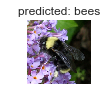

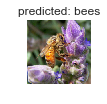

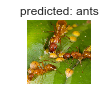

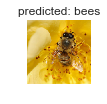

model train: False


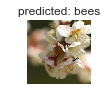

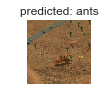

In [52]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [55]:
dataloaders["train"].num_workers

4